#### Library

In [11]:
import pandas as pd
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

#### Data Loading

In [2]:
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [3]:
print(df2021.shape)
print(df2022.shape)
print(df2023.shape)
print(df2024.shape)

(8763, 69)
(8763, 69)
(8763, 69)
(8787, 69)


In [4]:
df = pd.concat([df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [5]:
df.shape

(35076, 69)

In [6]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,1,53,1,2021,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,1,53,1,2021,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,1,53,1,2021,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


In [7]:
# Check for missing values
df.isnull( ).sum().sort_values(ascending=False)

datetime_                         0
pool_price_lag_24                 0
alberta_internal_load_lag_6       0
alberta_internal_load_lag_5       0
alberta_internal_load_lag_4       0
alberta_internal_load_lag_3       0
alberta_internal_load_lag_2       0
alberta_internal_load_lag_1       0
pool_price_lag_23                 0
pool_price_lag_15                 0
pool_price_lag_22                 0
pool_price_lag_21                 0
pool_price_lag_20                 0
pool_price_lag_19                 0
pool_price_lag_18                 0
pool_price_lag_17                 0
alberta_internal_load_lag_7       0
alberta_internal_load_lag_8       0
alberta_internal_load_lag_9       0
alberta_internal_load_lag_10      0
alberta_internal_load_lag_11      0
alberta_internal_load_lag_12      0
alberta_internal_load_lag_13      0
alberta_internal_load_lag_14      0
alberta_internal_load_lag_15      0
alberta_internal_load_lag_16      0
alberta_internal_load_lag_17      0
alberta_internal_load_lag_18

#### Train-Test split

In [8]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-07-01']
test_data = df[df['datetime_'] >= '2024-07-01']

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the test data
print(X_test.shape, y_test.shape)

(30657, 67) (30657,)
(4419, 67) (4419,)


#### Model Training

In [9]:
# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=5000, learning_rate=0.1, depth=6, loss_function='RMSE')

# # Specify the categorical features
# categorical_features = ['season'] 

# Train the model
catboost_regressor.fit(X_train, y_train, verbose=100) #cat_features=categorical_features, 

# Display the model
print(catboost_regressor)

0:	learn: 159.2000903	total: 104ms	remaining: 8m 41s
100:	learn: 54.8107991	total: 5.3s	remaining: 4m 17s
200:	learn: 50.1243062	total: 10.6s	remaining: 4m 12s
300:	learn: 46.4905537	total: 16s	remaining: 4m 10s
400:	learn: 43.7925949	total: 21.7s	remaining: 4m 8s
500:	learn: 41.3851997	total: 25.7s	remaining: 3m 50s
600:	learn: 39.3897507	total: 29.9s	remaining: 3m 38s
700:	learn: 37.3872876	total: 34.7s	remaining: 3m 32s
800:	learn: 35.5615421	total: 38.6s	remaining: 3m 22s
900:	learn: 33.8688359	total: 42.1s	remaining: 3m 11s
1000:	learn: 32.3779587	total: 45s	remaining: 2m 59s
1100:	learn: 31.0057877	total: 48.3s	remaining: 2m 51s
1200:	learn: 29.7363729	total: 51.2s	remaining: 2m 41s
1300:	learn: 28.5812125	total: 53.9s	remaining: 2m 33s
1400:	learn: 27.4857524	total: 57.1s	remaining: 2m 26s
1500:	learn: 26.4296484	total: 60s	remaining: 2m 19s
1600:	learn: 25.4676754	total: 1m 3s	remaining: 2m 15s
1700:	learn: 24.5309322	total: 1m 7s	remaining: 2m 9s
1800:	learn: 23.6633864	total:

#### Train Inference

In [12]:
# Make predictions on the training data
y_train_pred = catboost_regressor.predict(X_train)

# Calculate mean squared error for training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {train_mse}")

mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Mean Absolute Error: {mae}")

# Calculate R^2 score for training data
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train R^2 Score: {train_r2}")

Train Mean Squared Error: 94.99139279558972
Train Mean Absolute Error: 6.245550572938019
Train R^2 Score: 0.9968241303956437


#### Test Inference

In [13]:
# Make predictions on the test data
y_test_pred = catboost_regressor.predict(X_test)

# Calculate mean squared error for test data
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse}")

test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test Mean Absolute Error: {test_mae}")

# Calculate R^2 score for test data
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test R^2 Score: {test_r2}")

Test Mean Squared Error: 2029.2685380573796
Test Mean Absolute Error: 22.672422874946548
Test R^2 Score: 0.8513121061906044


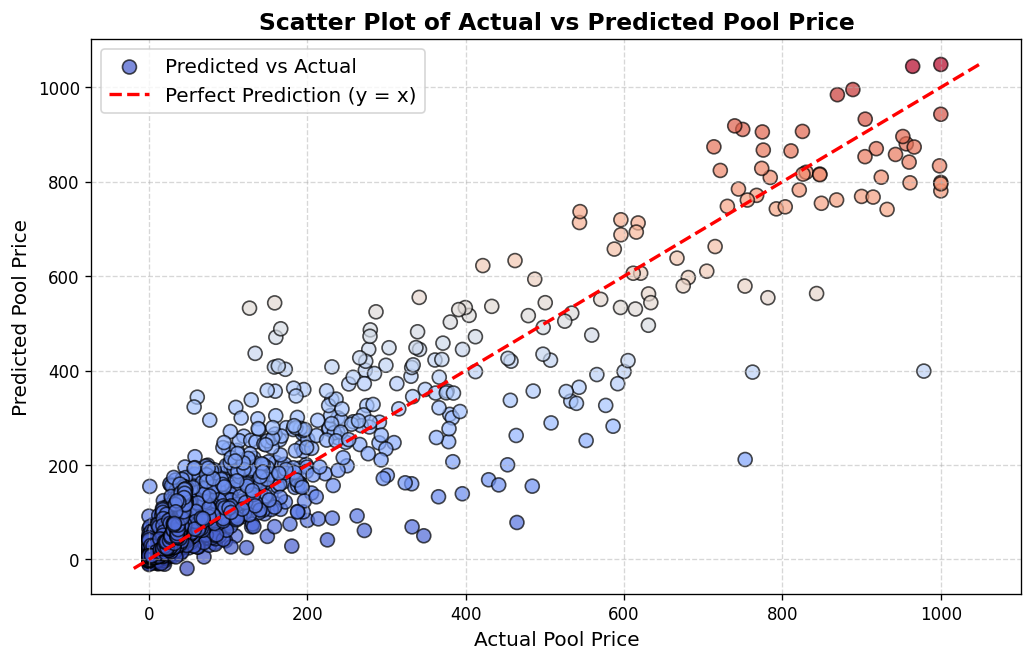

In [16]:
# Generate values for the y = x reference line
min_val = min(min(y_test), min(y_test_pred))
max_val = max(max(y_test), max(y_test_pred))
line_values = np.linspace(min_val, max_val, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6), dpi=120)

# Use color gradient for better visibility
plt.scatter(y_test, y_test_pred, alpha=0.7, c=y_test_pred, cmap='coolwarm', edgecolors='k', s=70, label='Predicted vs Actual')

# Plot the y = x line
plt.plot(line_values, line_values, color='red', linestyle='--', linewidth=2, label='Perfect Prediction (y = x)')

# Add labels and title
plt.xlabel('Actual Pool Price', fontsize=12)
plt.ylabel('Predicted Pool Price', fontsize=12)
plt.title('Scatter Plot of Actual vs Predicted Pool Price', fontsize=14, fontweight='bold')

# Add a legend
plt.legend(fontsize=12, loc='upper left')

# Add grid with transparency
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()


In [17]:
# Create a dataframe of the actual and predicted values
results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
results_df.head()

,y_test,y_test_pred
30657,14.69,15.262196
30658,16.23,15.227801
30659,15.77,14.690007
30660,13.85,13.864608
30661,13.58,12.985379


In [18]:
terget_df = results_df[results_df['y_test'] <= 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 18.35942962388144
R² Score test set: -0.14147250163612712


In [19]:
terget_df = results_df[results_df['y_test'] > 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (216, 2)
Mean Absolute Error on the test set : 106.59608321858842
R² Score test set: 0.6702244929566235
